# Thrills & Mysteries - Book Recommender System
Notebook 3: Cluster-Aware Recommendation Engine & Comprehensive Evaluation

name: Sai Sneha Siddapura Venkataramappa
uniqname: saisneha

This notebook handles:
1. Building the cluster-aware recommendation engine
2. Comprehensive evaluation metrics
3. Model interpretability and explainability
4. Alpha/beta/gamma parameter sweep for optimal weighting
5. Final results and analysis

In [1]:
import os
import gc
import pickle
import warnings
from pathlib import Path
from collections import Counter
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

warnings.filterwarnings("ignore")

# Set random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Imports successful")

Imports successful


In [2]:
# Recommendation parameters
TOP_K_RECOMMENDATIONS = 10
ALPHA_CONTENT = 0.5   # Weight for content similarity
ALPHA_GENRE = 0.4     # Weight for genre similarity
ALPHA_CLUSTER = 0.1   # Weight for cluster bonus
SIMILARITY_BATCH_SIZE = 500

# Evaluation parameters
EVAL_SAMPLE_SIZE = 1000  # Sample size for evaluation
EVAL_TOP_K = 5

print("Configuration:")
print(f"  Top-K recommendations: {TOP_K_RECOMMENDATIONS}")
print(f"  Alpha (content): {ALPHA_CONTENT}, Beta (genre): {ALPHA_GENRE}, Gamma (cluster): {ALPHA_CLUSTER}")
print(f"  Evaluation sample size: {EVAL_SAMPLE_SIZE}")

Configuration:
  Top-K recommendations: 10
  Alpha (content): 0.5, Beta (genre): 0.4, Gamma (cluster): 0.1
  Evaluation sample size: 1000


In [3]:
BASE_DIR = Path.cwd()
CHECKPOINTS_DIR = BASE_DIR / "checkpoints"
EMBEDDINGS_DIR = BASE_DIR / "embeddings"
GRAPHS_DIR = BASE_DIR / "graphs"
RESULTS_DIR = BASE_DIR / "results"

RESULTS_DIR.mkdir(exist_ok=True)

print("Directory structure ready")

Directory structure ready


In [4]:
print("LOADING CHECKPOINTS")

# Load checkpoint 1 (data)
print("Loading checkpoint 1...")
with open(CHECKPOINTS_DIR / 'checkpoint_1_data_prepared.pkl', 'rb') as f:
    checkpoint_1 = pickle.load(f)

df_mt = checkpoint_1['df_mt']
df_train = checkpoint_1['df_train']
df_test = checkpoint_1['df_test']

print(f"Loaded data: {len(df_train):,} train, {len(df_test):,} test")

# Load checkpoint 2 (embeddings info)
print("Loading checkpoint 2...")
with open(CHECKPOINTS_DIR / 'checkpoint_2_embeddings.pkl', 'rb') as f:
    checkpoint_2 = pickle.load(f)

best_model_name = checkpoint_2['best_model_name']
optimal_k = checkpoint_2['optimal_k']
print(f"Best model: {best_model_name}")
print(f"Optimal K: {optimal_k}")

# Load embeddings from disk
print(f"\nLoading {best_model_name} embeddings from disk...")
model_dir = EMBEDDINGS_DIR / ("miniLM" if best_model_name == "MiniLM" else "mpnet")

train_embeddings = np.load(model_dir / 'train_embeddings.npy')
test_embeddings = np.load(model_dir / 'test_embeddings.npy')

print(f"Loaded embeddings:")
print(f"  Train: {train_embeddings.shape}")
print(f"  Test: {test_embeddings.shape}")

LOADING CHECKPOINTS
Loading checkpoint 1...
Loaded data: 6,217 train, 1,555 test
Loading checkpoint 2...
Best model: MPNet
Optimal K: 9

Loading MPNet embeddings from disk...
Loaded embeddings:
  Train: (6217, 768)
  Test: (1555, 768)


In [5]:
print("LOADING CLUSTER ASSIGNMENTS")

# Load df_plot with cluster assignments
df_plot = checkpoint_2['df_plot']
umap_sample_indices = checkpoint_2['umap_sample_indices']

# Map cluster assignments back to full training data
train_clusters = np.full(len(df_train), -1)  # -1 for unassigned
train_clusters[umap_sample_indices] = df_plot['cluster'].values

# Add to df_train
df_train['kmeans_cluster'] = train_clusters

print(f"Loaded KMeans clusters (K={optimal_k})")
print(f"Clustered samples: {np.sum(train_clusters != -1):,}")
print(f"Unclustered: {np.sum(train_clusters == -1):,}")

# Cluster names
CLUSTER_NAMES = {
    0: "Domestic & Psychological Thrillers",
    1: "Horror & Supernatural Mysteries",
    2: "Police Procedurals & Detective Fiction",
    3: "Literary & British Mysteries",
    4: "Comics & Graphic Novels",
    5: "Romantic Suspense",
    6: "Espionage & Military Thrillers",
    7: "True Crime & Crime Journalism",
    8: "Historical Mysteries"
}

print("\nCluster distribution:")
for cluster_id in range(optimal_k):
    count = np.sum(train_clusters == cluster_id)
    print(f"  Cluster {cluster_id} ({CLUSTER_NAMES[cluster_id]}): {count} books")

LOADING CLUSTER ASSIGNMENTS
Loaded KMeans clusters (K=9)
Clustered samples: 6,217
Unclustered: 0

Cluster distribution:
  Cluster 0 (Domestic & Psychological Thrillers): 1226 books
  Cluster 1 (Horror & Supernatural Mysteries): 517 books
  Cluster 2 (Police Procedurals & Detective Fiction): 703 books
  Cluster 3 (Literary & British Mysteries): 908 books
  Cluster 4 (Comics & Graphic Novels): 327 books
  Cluster 5 (Romantic Suspense): 900 books
  Cluster 6 (Espionage & Military Thrillers): 683 books
  Cluster 7 (True Crime & Crime Journalism): 468 books
  Cluster 8 (Historical Mysteries): 485 books


In [6]:
print("PREPARING GENRE VECTORS")

# Combine train and test for consistent encoding
all_genres_list = []

# Extract unique genres
print("Extracting unique genres...")
for genres in tqdm(df_mt['genres'], desc="Processing genres"):
    if isinstance(genres, list):
        all_genres_list.extend(genres)
    else:
        if pd.notna(genres):
            all_genres_list.extend([g.strip() for g in str(genres).split(',')])

unique_genres = sorted(set(all_genres_list))
print(f"Found {len(unique_genres)} unique genres")

# Create MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=unique_genres)
mlb.fit([unique_genres])

# Encode genres for train and test
def encode_genres_batched(df, mlb, batch_size=1000):
    """Encode genres in batches"""
    encoded = []
    for i in tqdm(range(0, len(df), batch_size), desc="Encoding genres"):
        batch = df['genres'].iloc[i:i+batch_size]
        batch_encoded = mlb.transform(batch)
        encoded.append(batch_encoded)
    return np.vstack(encoded)

print("Encoding train genres...")
train_genre_matrix = encode_genres_batched(df_train, mlb)

print("Encoding test genres...")
test_genre_matrix = encode_genres_batched(df_test, mlb)

print(f"✓ Genre matrices created:")
print(f"  Train: {train_genre_matrix.shape}")
print(f"  Test: {test_genre_matrix.shape}")

PREPARING GENRE VECTORS
Extracting unique genres...


Processing genres: 100%|██████████| 7772/7772 [00:00<00:00, 272366.05it/s]


Found 751 unique genres
Encoding train genres...


Encoding genres: 100%|██████████| 7/7 [00:00<00:00, 66.97it/s]


Encoding test genres...


Encoding genres: 100%|██████████| 2/2 [00:00<00:00, 135.88it/s]


✓ Genre matrices created:
  Train: (6217, 751)
  Test: (1555, 751)


In [7]:
print("BUILDING RECOMMENDATION ENGINE")

class ClusterAwareRecommender:
    """
    Cluster-aware hybrid recommender combining:
    1. Content similarity (embeddings)
    2. Genre similarity (Jaccard)
    3. Cluster membership (KMeans sub-genres)
    """

    def __init__(self, df, embeddings, genre_matrix, clusters,
                 alpha_content=0.5, alpha_genre=0.3, alpha_cluster=0.2):
        """
        Parameters:
        -----------
        alpha_content : float
            Weight for content similarity
        alpha_genre : float
            Weight for genre similarity
        alpha_cluster : float
            Weight for same-cluster bonus

        Note: alpha_content + alpha_genre + alpha_cluster should = 1.0
        """
        self.df = df
        self.embeddings = embeddings
        self.genre_matrix = genre_matrix
        self.clusters = clusters
        self.alpha_content = alpha_content
        self.alpha_genre = alpha_genre
        self.alpha_cluster = alpha_cluster

        # Normalize embeddings
        print("Normalizing embeddings...")
        self.norm_embeddings = embeddings / np.linalg.norm(
            embeddings, axis=1, keepdims=True
        )

        # Validate only clustered books
        self.clustered_mask = clusters != -1
        print(f"  Recommender initialized")
        print(f"  Weights: content={alpha_content}, genre={alpha_genre}, cluster={alpha_cluster}")
        print(f"  Clustered books: {np.sum(self.clustered_mask):,}/{len(clusters):,}")

    def compute_content_similarity(self, query_idx):
        """Compute content-based similarity"""
        query_emb = self.norm_embeddings[query_idx].reshape(1, -1)
        similarities = np.dot(self.norm_embeddings, query_emb.T).flatten()
        similarities[query_idx] = -1  # Exclude self
        return similarities

    def compute_genre_similarity(self, query_idx):
        """Compute genre-based similarity (Jaccard)"""
        query_genres = self.genre_matrix[query_idx]
        intersection = np.dot(self.genre_matrix, query_genres)
        union = (self.genre_matrix.sum(axis=1) + query_genres.sum() - intersection)
        union = np.where(union == 0, 1, union)
        similarities = intersection / union
        return similarities

    def compute_cluster_bonus(self, query_idx):
        """Compute cluster membership bonus"""
        query_cluster = self.clusters[query_idx]

        # If query not in cluster, no bonus
        if query_cluster == -1:
            return np.zeros(len(self.clusters))

        # Bonus for same cluster
        same_cluster = (self.clusters == query_cluster).astype(float)
        return same_cluster

    def recommend(self, query_idx, top_k=10, within_cluster_only=False):
        """
        Generate cluster-aware hybrid recommendations

        Parameters:
        -----------
        within_cluster_only : bool
            If True, only recommend from same cluster (sub-genre specific)
        """
        # Compute all similarities
        content_sim = self.compute_content_similarity(query_idx)
        genre_sim = self.compute_genre_similarity(query_idx)
        cluster_bonus = self.compute_cluster_bonus(query_idx)

        # Combined hybrid score
        hybrid_scores = (
            self.alpha_content * content_sim +
            self.alpha_genre * genre_sim +
            self.alpha_cluster * cluster_bonus
        )

        # If within_cluster_only, mask out other clusters
        if within_cluster_only and self.clusters[query_idx] != -1:
            query_cluster = self.clusters[query_idx]
            cluster_mask = self.clusters == query_cluster
            hybrid_scores = np.where(cluster_mask, hybrid_scores, -np.inf)

        # Get top-k
        hybrid_scores[query_idx] = -np.inf  # Exclude self
        top_indices = np.argsort(hybrid_scores)[-top_k:][::-1]

        # Prepare results
        results = []
        for idx in top_indices:
            if hybrid_scores[idx] == -np.inf:
                continue

            results.append({
                'index': idx,
                'title': self.df.iloc[idx]['title'],
                'author': self.df.iloc[idx]['author'],
                'cluster': int(self.clusters[idx]) if self.clusters[idx] != -1 else None,
                'cluster_name': CLUSTER_NAMES.get(self.clusters[idx], 'Unclustered'),
                'content_sim': float(content_sim[idx]),
                'genre_sim': float(genre_sim[idx]),
                'cluster_bonus': float(cluster_bonus[idx]),
                'hybrid_score': float(hybrid_scores[idx])
            })

        return results

    def recommend_with_diversity(self, query_idx, top_k=10,
                                 within_cluster=7, cross_cluster=3):
        """
        Balanced recommendations: some from same cluster, some from others

        Parameters:
        -----------
        within_cluster : int
            Number of recommendations from same cluster
        cross_cluster : int
            Number of recommendations from different clusters
        """
        # Get within-cluster recommendations
        within_recs = self.recommend(query_idx, top_k=within_cluster,
                                    within_cluster_only=True)

        # Get cross-cluster recommendations
        all_recs = self.recommend(query_idx, top_k=top_k*2,
                                 within_cluster_only=False)

        # Filter out same-cluster ones
        query_cluster = self.clusters[query_idx]
        cross_recs = [r for r in all_recs
                     if r['cluster'] != query_cluster and r['cluster'] is not None]
        cross_recs = cross_recs[:cross_cluster]

        # Combine
        combined = within_recs + cross_recs

        # Re-sort by hybrid score
        combined.sort(key=lambda x: x['hybrid_score'], reverse=True)

        return combined[:top_k]

# Initialize cluster-aware recommender
recommender = ClusterAwareRecommender(
    df_train,
    train_embeddings,
    train_genre_matrix,
    train_clusters,
    alpha_content=ALPHA_CONTENT,
    alpha_genre=ALPHA_GENRE,
    alpha_cluster=ALPHA_CLUSTER
)

print(f"Cluster-aware recommender ready")

BUILDING RECOMMENDATION ENGINE
Normalizing embeddings...
  Recommender initialized
  Weights: content=0.5, genre=0.4, cluster=0.1
  Clustered books: 6,217/6,217
Cluster-aware recommender ready


# Testing Reccomendations

In [8]:
print("TESTING RECOMMENDATIONS")

print("\nEXAMPLE 1: COMICS & GRAPHIC NOVELS")

test_idx_1 = 0  # Supercrooks
query_book = df_train.iloc[test_idx_1]

print(f"\nQuery Book: {query_book['title']}")
print(f"Author: {query_book['author']}")
print(f"Cluster: {CLUSTER_NAMES.get(train_clusters[test_idx_1], 'Unclustered')}")

print("WITHIN-CLUSTER RECOMMENDATIONS (Same Sub-genre)")
within_recs = recommender.recommend(test_idx_1, top_k=5, within_cluster_only=True)

for i, rec in enumerate(within_recs, 1):
    print(f"\n{i}. {rec['title']}")
    print(f"   Author: {rec['author']}")
    print(f"   Cluster: {rec['cluster_name']}")
    print(f"   Scores: Content={rec['content_sim']:.3f}, Genre={rec['genre_sim']:.3f}, Cluster={rec['cluster_bonus']:.1f}")
    print(f"   Hybrid: {rec['hybrid_score']:.3f}")

# Example 2: Psychological Thriller (Demonstrates cross-cluster diversity)
print("EXAMPLE 2: DOMESTIC & PSYCHOLOGICAL THRILLERS")

# Find a psychological thriller
test_idx_2 = df_train[df_train['kmeans_cluster'] == 0].index[0]
query_book = df_train.iloc[test_idx_2]

print(f"\nQuery Book: {query_book['title']}")
print(f"Author: {query_book['author']}")
print(f"Cluster: {CLUSTER_NAMES.get(train_clusters[test_idx_2], 'Unclustered')}")

# Balanced (within + cross cluster)
print("BALANCED RECOMMENDATIONS (Within + Cross-cluster)")
balanced_recs = recommender.recommend_with_diversity(test_idx_2, top_k=10,
                                                     within_cluster=7, cross_cluster=3)

for i, rec in enumerate(balanced_recs, 1):
    query_cluster = train_clusters[test_idx_2]
    same_cluster_marker = "SAME-CLUSTER" if rec['cluster'] == query_cluster else "CROSS-CLUSTER"
    print(f"\n{i}. [{same_cluster_marker}] {rec['title']}")
    print(f"   Author: {rec['author']}")
    print(f"   Cluster: {rec['cluster_name']}")
    print(f"   Hybrid Score: {rec['hybrid_score']:.3f}")


TESTING RECOMMENDATIONS

EXAMPLE 1: COMICS & GRAPHIC NOVELS

Query Book: Supercrooks
Author: Mark Millar,Leinil Francis Yu
Cluster: Comics & Graphic Novels
WITHIN-CLUSTER RECOMMENDATIONS (Same Sub-genre)

1. Daredevil, Vol. 4: Underboss
   Author: Brian Michael Bendis,Alex Maleev,Joe Quesada
   Cluster: Comics & Graphic Novels
   Scores: Content=0.453, Genre=1.000, Cluster=1.0
   Hybrid: 0.726

2. Powers, Vol. 4: Supergroup
   Author: Brian Michael Bendis,Michael Avon Oeming
   Cluster: Comics & Graphic Novels
   Scores: Content=0.485, Genre=0.917, Cluster=1.0
   Hybrid: 0.709

3. Kick-Ass 2 Prelude: Hit-Girl
   Author: Mark Millar,John Romita Jr.,Tom Palmer,Dean White,Michael Kelleher,Scott Snyder
   Cluster: Comics & Graphic Novels
   Scores: Content=0.365, Genre=1.000, Cluster=1.0
   Hybrid: 0.682

4. Powers, Vol. 5: Anarchy
   Author: Brian Michael Bendis
   Cluster: Comics & Graphic Novels
   Scores: Content=0.523, Genre=0.769, Cluster=1.0
   Hybrid: 0.669

5. Daredevil by Mark Wa

# Evaluation

In [9]:
def evaluate_recommender(recommender, sample_size=1000, top_k=5):
    """Comprehensive evaluation of recommendation quality"""

    # Sample indices for evaluation (only clustered books)
    clustered_indices = np.where(recommender.clusters != -1)[0]
    eval_indices = np.random.choice(
        clustered_indices,
        min(sample_size, len(clustered_indices)),
        replace=False
    )

    metrics = {
        'diversity': [],
        'novelty': [],
        'coverage': set(),
        'genre_precision': [],
        'serendipity': [],
        'avg_content_sim': [],
        'avg_genre_sim': [],
        'avg_cluster_bonus': [],
        'within_cluster_rate': []
    }

    print(f"Evaluating on {len(eval_indices)} samples...")

    for idx in tqdm(eval_indices, desc="Evaluation"):
        recs = recommender.recommend(idx, top_k=top_k)

        if len(recs) == 0:
            continue

        # Extract indices
        rec_indices = [r['index'] for r in recs]

        # 1. Diversity: average pairwise distance between recommendations
        rec_embs = recommender.norm_embeddings[rec_indices]
        pairwise_sims = np.dot(rec_embs, rec_embs.T)
        np.fill_diagonal(pairwise_sims, 0)
        diversity = 1 - (pairwise_sims.sum() / (len(rec_indices) * (len(rec_indices) - 1)) if len(rec_indices) > 1 else 0)
        metrics['diversity'].append(diversity)

        # 2. Novelty: inverse popularity (use rating_count if available)
        if 'rating_count' in recommender.df.columns:
            pop_scores = recommender.df.iloc[rec_indices]['rating_count'].values
            pop_scores = np.nan_to_num(pop_scores, nan=1.0)
            novelty = np.mean(1 / (1 + np.log1p(pop_scores)))
            metrics['novelty'].append(novelty)

        # 3. Coverage: unique books recommended
        metrics['coverage'].update(rec_indices)

        # 4. Genre Precision: % of recommendations sharing genres
        query_genres = set(recommender.df.iloc[idx]['genres'])
        for rec_idx in rec_indices:
            rec_genres = set(recommender.df.iloc[rec_idx]['genres'])
            overlap = len(query_genres & rec_genres) / len(query_genres) if query_genres else 0
            metrics['genre_precision'].append(overlap)

        # 5. Serendipity: high similarity but different primary genre
        query_primary = recommender.df.iloc[idx]['genres'][0] if recommender.df.iloc[idx]['genres'] else None
        for r in recs:
            rec_primary = recommender.df.iloc[r['index']]['genres'][0] if recommender.df.iloc[r['index']]['genres'] else None
            if query_primary != rec_primary and r['content_sim'] > 0.5:
                metrics['serendipity'].append(r['content_sim'])

        # 6. Average similarities
        metrics['avg_content_sim'].append(np.mean([r['content_sim'] for r in recs]))
        metrics['avg_genre_sim'].append(np.mean([r['genre_sim'] for r in recs]))
        metrics['avg_cluster_bonus'].append(np.mean([r['cluster_bonus'] for r in recs]))

        # 7. Within-cluster rate
        query_cluster = recommender.clusters[idx]
        within_cluster_count = sum(1 for r in recs if r['cluster'] == query_cluster)
        metrics['within_cluster_rate'].append(within_cluster_count / len(recs))

    # Aggregate results
    results = {
        'diversity': np.mean(metrics['diversity']),
        'novelty': np.mean(metrics['novelty']) if metrics['novelty'] else 0,
        'coverage': len(metrics['coverage']) / len(recommender.df),
        'genre_precision': np.mean(metrics['genre_precision']),
        'serendipity_score': np.mean(metrics['serendipity']) if metrics['serendipity'] else 0,
        'serendipity_rate': len(metrics['serendipity']) / (len(eval_indices) * top_k),
        'avg_content_similarity': np.mean(metrics['avg_content_sim']),
        'avg_genre_similarity': np.mean(metrics['avg_genre_sim']),
        'avg_cluster_bonus': np.mean(metrics['avg_cluster_bonus']),
        'within_cluster_rate': np.mean(metrics['within_cluster_rate'])
    }

    return results

In [10]:
print("\nRunning comprehensive evaluation...")
eval_results = evaluate_recommender(
    recommender,
    sample_size=EVAL_SAMPLE_SIZE,
    top_k=EVAL_TOP_K
)

print("EVALUATION RESULTS")

for metric, value in eval_results.items():
    if isinstance(value, float):
        print(f"{metric:.<40} {value:.4f}")
    else:
        print(f"{metric:.<40} {value}")


Running comprehensive evaluation...
Evaluating on 1000 samples...


Evaluation: 100%|██████████| 1000/1000 [00:21<00:00, 47.18it/s]

EVALUATION RESULTS
diversity............................... 0.4789608120918274
novelty................................. 0
coverage................................ 0.4644
genre_precision......................... 0.7692
serendipity_score....................... 0.5890
serendipity_rate........................ 0.2332
avg_content_similarity.................. 0.5400
avg_genre_similarity.................... 0.6397
avg_cluster_bonus....................... 0.9188
within_cluster_rate..................... 0.9188


In [11]:
# Interpretation
print("\nInterpretation:")
print(f"  Diversity (0-1, higher=better): {eval_results['diversity']:.3f}")
print(f"    → Recommendations are {'diverse' if eval_results['diversity'] > 0.5 else 'similar'}")
print(f"  Genre Precision (0-1, higher=better): {eval_results['genre_precision']:.3f}")
print(f"    → {eval_results['genre_precision']*100:.1f}% genre overlap on average")
print(f"  Coverage (0-1, higher=better): {eval_results['coverage']:.3f}")
print(f"    → {eval_results['coverage']*100:.1f}% of catalog gets recommended")
print(f"  Within-Cluster Rate: {eval_results['within_cluster_rate']*100:.1f}%")
print(f"    → {eval_results['within_cluster_rate']*100:.1f}% of recommendations from same cluster")
print(f"  Serendipity Rate: {eval_results['serendipity_rate']*100:.1f}%")
print(f"    → Surprising but relevant recommendations")


Interpretation:
  Diversity (0-1, higher=better): 0.479
    → Recommendations are similar
  Genre Precision (0-1, higher=better): 0.769
    → 76.9% genre overlap on average
  Coverage (0-1, higher=better): 0.464
    → 46.4% of catalog gets recommended
  Within-Cluster Rate: 91.9%
    → 91.9% of recommendations from same cluster
  Serendipity Rate: 23.3%
    → Surprising but relevant recommendations


In [12]:
print("WEIGHT PARAMETER SWEEP")

# Define weight combinations to test
# Format: (alpha_content, alpha_genre, alpha_cluster)
weight_configs = [
    (0.7, 0.3, 0.0),  # Content + Genre (no cluster)
    (0.6, 0.3, 0.1),  # Slight cluster boost
    (0.5, 0.3, 0.2),  # Balanced (default)
    (0.4, 0.3, 0.3),  # Higher cluster influence
    (0.5, 0.2, 0.3),  # Content + Cluster focus
    (0.0, 0.7, 0.3),  # Genre + Cluster focus
    (0.33, 0.34, 0.33), # Equal weights
]

weight_results = []

print("Testing different weight combinations...")
print("Format: (content_weight, genre_weight, cluster_weight)")

for alpha_c, alpha_g, alpha_cl in tqdm(weight_configs, desc="Weight sweep"):
    temp_recommender = ClusterAwareRecommender(
        df_train,
        train_embeddings,
        train_genre_matrix,
        train_clusters,
        alpha_content=alpha_c,
        alpha_genre=alpha_g,
        alpha_cluster=alpha_cl
    )

    results = evaluate_recommender(
        temp_recommender,
        sample_size=min(500, EVAL_SAMPLE_SIZE),  # Smaller sample for speed
        top_k=EVAL_TOP_K
    )
    results['alpha_content'] = alpha_c
    results['alpha_genre'] = alpha_g
    results['alpha_cluster'] = alpha_cl
    results['config_name'] = f"C:{alpha_c:.1f}/G:{alpha_g:.1f}/Cl:{alpha_cl:.1f}"
    weight_results.append(results)

WEIGHT PARAMETER SWEEP
Testing different weight combinations...
Format: (content_weight, genre_weight, cluster_weight)


Weight sweep:   0%|          | 0/7 [00:00<?, ?it/s]

Normalizing embeddings...
  Recommender initialized
  Weights: content=0.7, genre=0.3, cluster=0.0
  Clustered books: 6,217/6,217
Evaluating on 500 samples...



Weight sweep:  14%|█▍        | 1/7 [00:12<01:14, 12.41s/it]

Normalizing embeddings...
  Recommender initialized
  Weights: content=0.6, genre=0.3, cluster=0.1
  Clustered books: 6,217/6,217
Evaluating on 500 samples...



Weight sweep:  29%|██▊       | 2/7 [00:23<00:58, 11.64s/it]

Normalizing embeddings...
  Recommender initialized
  Weights: content=0.5, genre=0.3, cluster=0.2
  Clustered books: 6,217/6,217
Evaluating on 500 samples...



Weight sweep:  43%|████▎     | 3/7 [00:33<00:42, 10.71s/it]

Normalizing embeddings...
  Recommender initialized
  Weights: content=0.4, genre=0.3, cluster=0.3
  Clustered books: 6,217/6,217
Evaluating on 500 samples...



Weight sweep:  57%|█████▋    | 4/7 [00:44<00:32, 10.88s/it]

Normalizing embeddings...
  Recommender initialized
  Weights: content=0.5, genre=0.2, cluster=0.3
  Clustered books: 6,217/6,217
Evaluating on 500 samples...



Weight sweep:  71%|███████▏  | 5/7 [00:55<00:22, 11.14s/it]

Normalizing embeddings...
  Recommender initialized
  Weights: content=0.0, genre=0.7, cluster=0.3
  Clustered books: 6,217/6,217
Evaluating on 500 samples...



Weight sweep:  86%|████████▌ | 6/7 [01:06<00:11, 11.04s/it]

Normalizing embeddings...
  Recommender initialized
  Weights: content=0.33, genre=0.34, cluster=0.33
  Clustered books: 6,217/6,217
Evaluating on 500 samples...



Weight sweep: 100%|██████████| 7/7 [01:17<00:00, 11.13s/it]


Saved: /content/graphs/weight_parameter_sweep.png


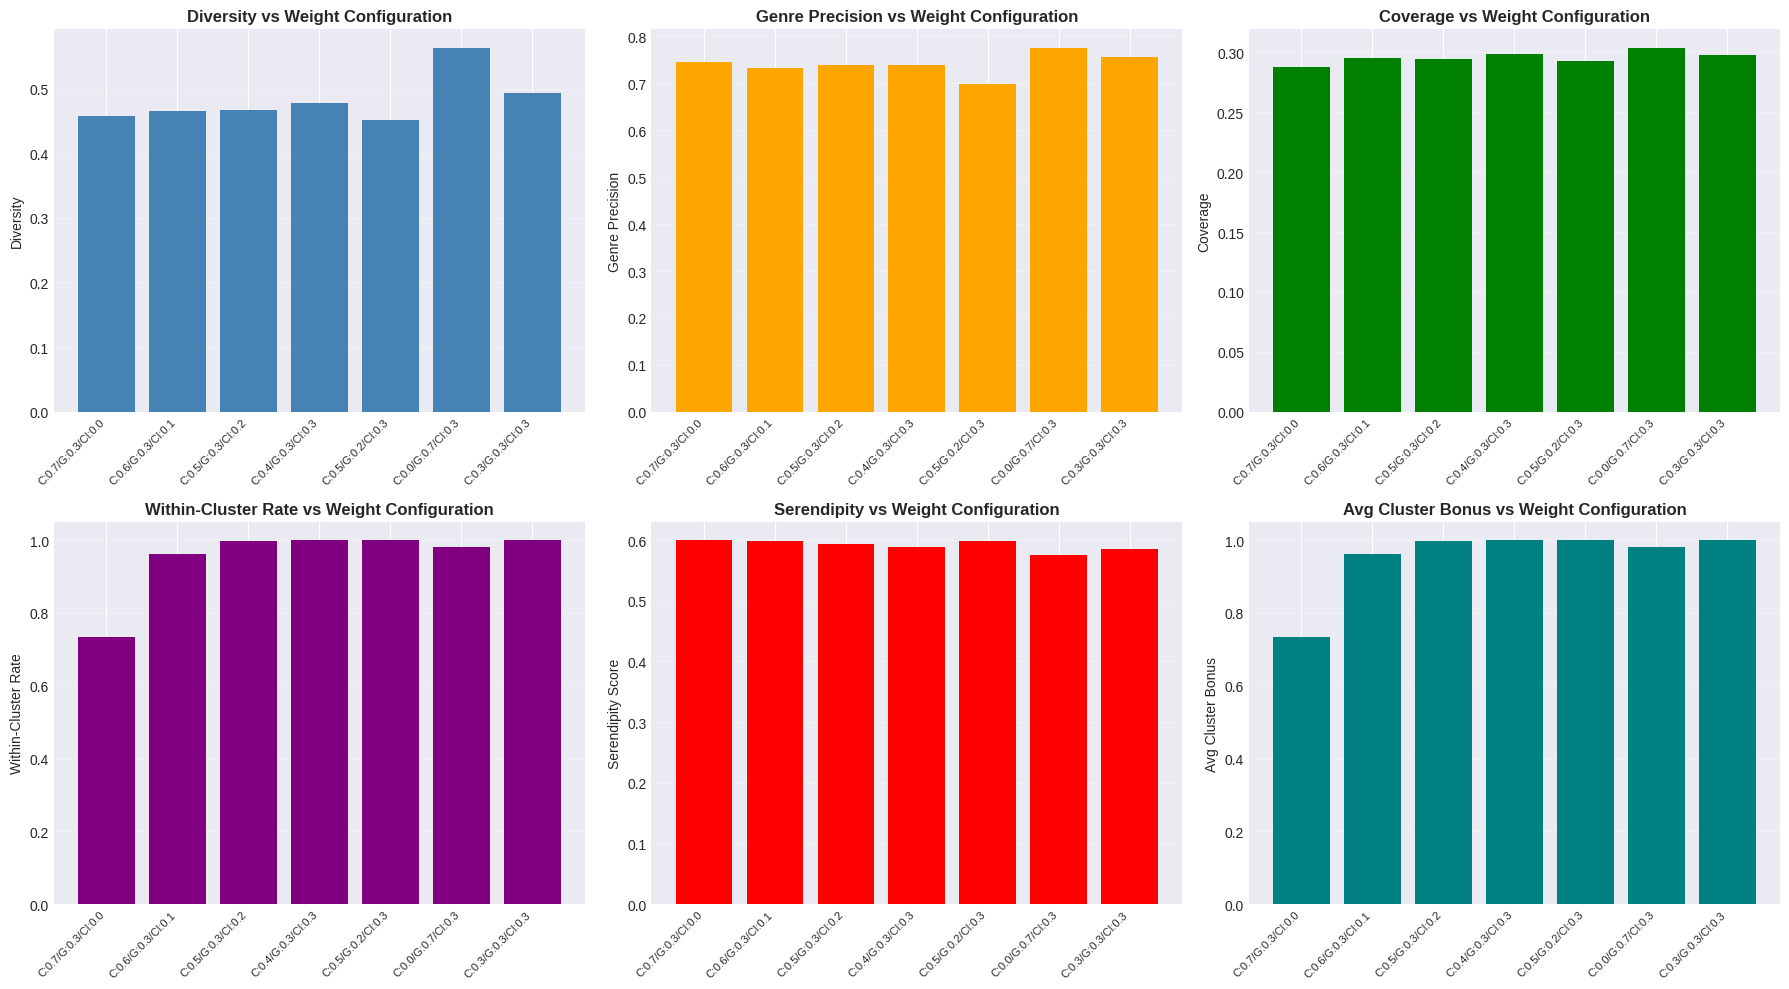

BEST CONFIGURATIONS BY METRIC

DIVERSITY:
  Config: C:0.0/G:0.7/Cl:0.3
  Value: 0.5634

GENRE_PRECISION:
  Config: C:0.0/G:0.7/Cl:0.3
  Value: 0.7761

COVERAGE:
  Config: C:0.0/G:0.7/Cl:0.3
  Value: 0.3040

WITHIN_CLUSTER_RATE:
  Config: C:0.5/G:0.2/Cl:0.3
  Value: 1.0000

SERENDIPITY_SCORE:
  Config: C:0.7/G:0.3/Cl:0.0
  Value: 0.5999


In [13]:
# Visualize weight sweep
weight_df = pd.DataFrame(weight_results)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Diversity
axes[0, 0].bar(range(len(weight_df)), weight_df['diversity'], color='steelblue')
axes[0, 0].set_xticks(range(len(weight_df)))
axes[0, 0].set_xticklabels(weight_df['config_name'], rotation=45, ha='right', fontsize=8)
axes[0, 0].set_ylabel('Diversity', fontsize=10)
axes[0, 0].set_title('Diversity vs Weight Configuration', fontweight='bold')
axes[0, 0].grid(alpha=0.3, axis='y')

# Genre Precision
axes[0, 1].bar(range(len(weight_df)), weight_df['genre_precision'], color='orange')
axes[0, 1].set_xticks(range(len(weight_df)))
axes[0, 1].set_xticklabels(weight_df['config_name'], rotation=45, ha='right', fontsize=8)
axes[0, 1].set_ylabel('Genre Precision', fontsize=10)
axes[0, 1].set_title('Genre Precision vs Weight Configuration', fontweight='bold')
axes[0, 1].grid(alpha=0.3, axis='y')

# Coverage
axes[0, 2].bar(range(len(weight_df)), weight_df['coverage'], color='green')
axes[0, 2].set_xticks(range(len(weight_df)))
axes[0, 2].set_xticklabels(weight_df['config_name'], rotation=45, ha='right', fontsize=8)
axes[0, 2].set_ylabel('Coverage', fontsize=10)
axes[0, 2].set_title('Coverage vs Weight Configuration', fontweight='bold')
axes[0, 2].grid(alpha=0.3, axis='y')

# Within-Cluster Rate
axes[1, 0].bar(range(len(weight_df)), weight_df['within_cluster_rate'], color='purple')
axes[1, 0].set_xticks(range(len(weight_df)))
axes[1, 0].set_xticklabels(weight_df['config_name'], rotation=45, ha='right', fontsize=8)
axes[1, 0].set_ylabel('Within-Cluster Rate', fontsize=10)
axes[1, 0].set_title('Within-Cluster Rate vs Weight Configuration', fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='y')

# Serendipity
axes[1, 1].bar(range(len(weight_df)), weight_df['serendipity_score'], color='red')
axes[1, 1].set_xticks(range(len(weight_df)))
axes[1, 1].set_xticklabels(weight_df['config_name'], rotation=45, ha='right', fontsize=8)
axes[1, 1].set_ylabel('Serendipity Score', fontsize=10)
axes[1, 1].set_title('Serendipity vs Weight Configuration', fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='y')

# Average Cluster Bonus
axes[1, 2].bar(range(len(weight_df)), weight_df['avg_cluster_bonus'], color='teal')
axes[1, 2].set_xticks(range(len(weight_df)))
axes[1, 2].set_xticklabels(weight_df['config_name'], rotation=45, ha='right', fontsize=8)
axes[1, 2].set_ylabel('Avg Cluster Bonus', fontsize=10)
axes[1, 2].set_title('Avg Cluster Bonus vs Weight Configuration', fontweight='bold')
axes[1, 2].grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(GRAPHS_DIR / 'weight_parameter_sweep.png', dpi=300, bbox_inches='tight')
print(f"Saved: {GRAPHS_DIR / 'weight_parameter_sweep.png'}")
plt.show()
plt.close()

# Print best configurations for each metric
print("BEST CONFIGURATIONS BY METRIC")

metrics_to_optimize = ['diversity', 'genre_precision', 'coverage', 'within_cluster_rate', 'serendipity_score']

for metric in metrics_to_optimize:
    best_idx = weight_df[metric].idxmax()
    best_config = weight_df.iloc[best_idx]
    print(f"\n{metric.upper()}:")
    print(f"  Config: {best_config['config_name']}")
    print(f"  Value: {best_config[metric]:.4f}")

In [14]:
print("BUILDING EXPLAINABILITY FUNCTIONS")

def explain_recommendation(query_idx, rec_idx, recommender, top_keywords=5):
    """
    Explain why a book was recommended with cluster information
    """
    query_book = recommender.df.iloc[query_idx]
    rec_book = recommender.df.iloc[rec_idx]

    # Compute similarities
    content_sim = float(np.dot(
        recommender.norm_embeddings[query_idx],
        recommender.norm_embeddings[rec_idx]
    ))
    genre_sim = recommender.compute_genre_similarity(query_idx)[rec_idx]
    cluster_bonus = recommender.compute_cluster_bonus(query_idx)[rec_idx]

    # Cluster information
    query_cluster = recommender.clusters[query_idx]
    rec_cluster = recommender.clusters[rec_idx]
    same_cluster = (query_cluster == rec_cluster and query_cluster != -1)

    # Shared genres
    query_genres = set(query_book['genres'])
    rec_genres = set(rec_book['genres'])
    shared_genres = query_genres & rec_genres

    # Extract key themes using TF-IDF
    texts = [query_book['clean_desc'], rec_book['clean_desc']]
    vectorizer = TfidfVectorizer(max_features=50, stop_words='english', ngram_range=(1,2))
    tfidf = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()

    # Find common keywords
    query_tfidf = tfidf[0].toarray().flatten()
    rec_tfidf = tfidf[1].toarray().flatten()
    common_scores = query_tfidf * rec_tfidf
    top_common_idx = np.argsort(common_scores)[-top_keywords:][::-1]
    common_keywords = [feature_names[i] for i in top_common_idx if common_scores[i] > 0]

    # Compute hybrid score
    hybrid_score = (
        recommender.alpha_content * content_sim +
        recommender.alpha_genre * genre_sim +
        recommender.alpha_cluster * cluster_bonus
    )

    explanation = {
        'query_book': query_book['title'],
        'query_author': query_book['author'],
        'query_cluster': CLUSTER_NAMES.get(query_cluster, 'Unclustered'),
        'recommended_book': rec_book['title'],
        'rec_author': rec_book['author'],
        'rec_cluster': CLUSTER_NAMES.get(rec_cluster, 'Unclustered'),
        'same_cluster': same_cluster,
        'content_similarity': content_sim,
        'genre_similarity': genre_sim,
        'cluster_bonus': cluster_bonus,
        'hybrid_score': hybrid_score,
        'shared_genres': list(shared_genres),
        'common_themes': common_keywords
    }

    return explanation

# Test explainability
print("\nTesting explainability...")
test_query_idx = 0
recs = recommender.recommend(test_query_idx, top_k=3)

print(f"\nQuery: {df_train.iloc[test_query_idx]['title']}")
print(f"Cluster: {CLUSTER_NAMES.get(train_clusters[test_query_idx], 'Unclustered')}")

for i, rec in enumerate(recs[:2], 1):
    print(f"\n{'-'*60}")
    print(f"Recommendation {i}:")
    exp = explain_recommendation(test_query_idx, rec['index'], recommender)
    print(f"  Book: {exp['recommended_book']} by {exp['rec_author']}")
    print(f"  Cluster: {exp['rec_cluster']} (Same: {exp['same_cluster']})")
    print(f"  Content Similarity: {exp['content_similarity']:.3f} (weight: {recommender.alpha_content})")
    print(f"  Genre Similarity: {exp['genre_similarity']:.3f} (weight: {recommender.alpha_genre})")
    print(f"  Cluster Bonus: {exp['cluster_bonus']:.3f} (weight: {recommender.alpha_cluster})")
    print(f"  Hybrid Score: {exp['hybrid_score']:.3f}")
    print(f"  Shared Genres: {', '.join(exp['shared_genres']) if exp['shared_genres'] else 'None'}")
    if exp['common_themes']:
        print(f"  Common Themes: {', '.join(exp['common_themes'][:3])}")

print("\n Explainability functions ready")

BUILDING EXPLAINABILITY FUNCTIONS

Testing explainability...

Query: Supercrooks
Cluster: Comics & Graphic Novels

------------------------------------------------------------
Recommendation 1:
  Book: Daredevil, Vol. 4: Underboss by Brian Michael Bendis,Alex Maleev,Joe Quesada
  Cluster: Comics & Graphic Novels (Same: True)
  Content Similarity: 0.453 (weight: 0.5)
  Genre Similarity: 1.000 (weight: 0.4)
  Cluster Bonus: 1.000 (weight: 0.1)
  Hybrid Score: 0.726
  Shared Genres: Sequential Art, Graphic Novels Comics, Crime, Fiction, Graphic Novels, Comic Book, Comics, Mystery, Marvel, Superheroes, Fantasy, Comix

------------------------------------------------------------
Recommendation 2:
  Book: Powers, Vol. 4: Supergroup by Brian Michael Bendis,Michael Avon Oeming
  Cluster: Comics & Graphic Novels (Same: True)
  Content Similarity: 0.485 (weight: 0.5)
  Genre Similarity: 0.917 (weight: 0.4)
  Cluster Bonus: 1.000 (weight: 0.1)
  Hybrid Score: 0.709
  Shared Genres: Sequential Art

ANALYZING CLUSTER DISTRIBUTION IN RECOMMENDATIONS
Computing cluster transition matrix...


Analyzing clusters: 100%|██████████| 500/500 [00:08<00:00, 57.40it/s]


Saved: /content/graphs/cluster_transition_matrix.png


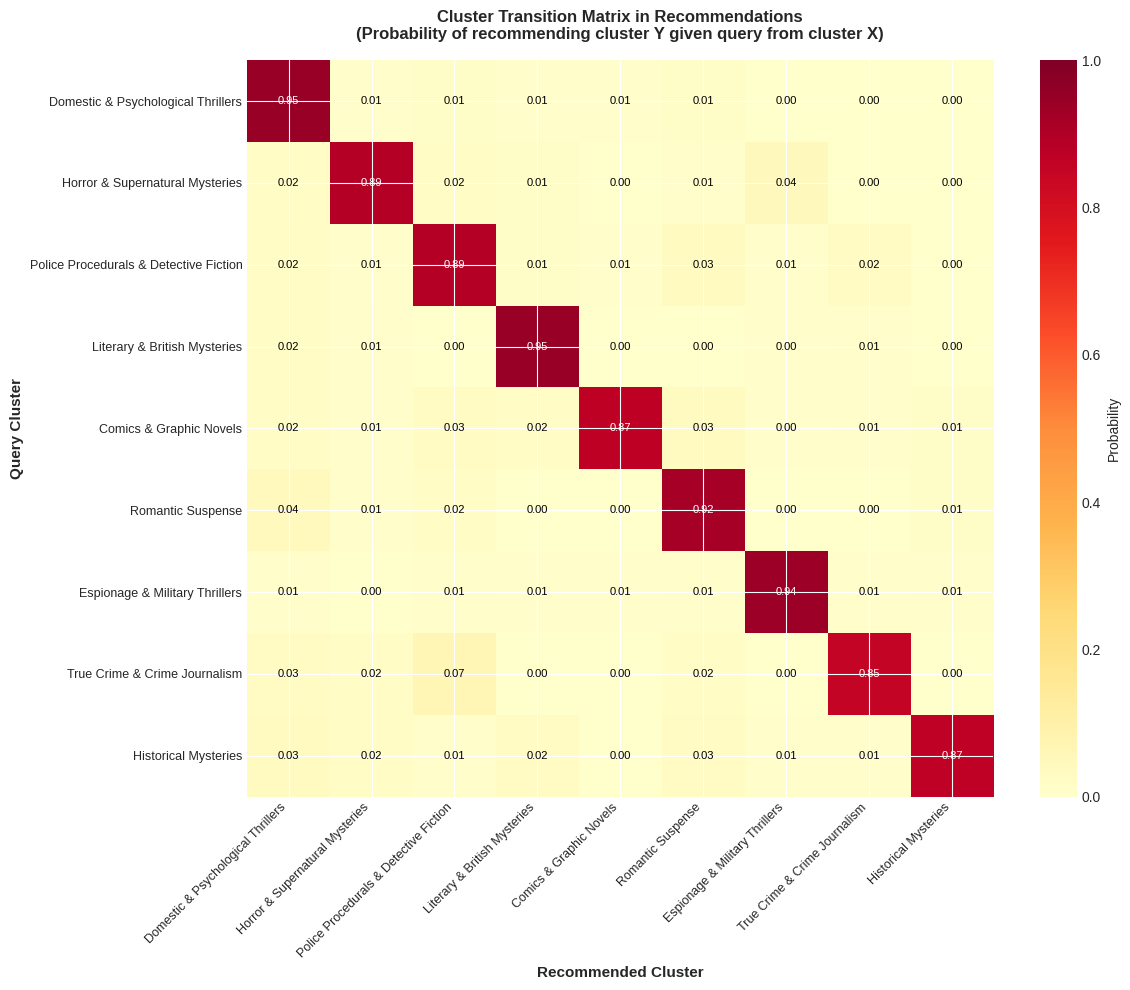


CLUSTER TRANSITION INSIGHTS

Domestic & Psychological Thrillers:
  Within-cluster recommendations: 94.6%
  Top cross-cluster recommendations:

Horror & Supernatural Mysteries:
  Within-cluster recommendations: 88.8%
  Top cross-cluster recommendations:

Police Procedurals & Detective Fiction:
  Within-cluster recommendations: 89.0%
  Top cross-cluster recommendations:

Literary & British Mysteries:
  Within-cluster recommendations: 94.8%
  Top cross-cluster recommendations:

Comics & Graphic Novels:
  Within-cluster recommendations: 87.1%
  Top cross-cluster recommendations:

Romantic Suspense:
  Within-cluster recommendations: 91.8%
  Top cross-cluster recommendations:

Espionage & Military Thrillers:
  Within-cluster recommendations: 93.8%
  Top cross-cluster recommendations:

True Crime & Crime Journalism:
  Within-cluster recommendations: 85.4%
  Top cross-cluster recommendations:
    Police Procedurals & Detective Fiction: 6.6%

Historical Mysteries:
  Within-cluster recommendati

In [15]:
print("ANALYZING CLUSTER DISTRIBUTION IN RECOMMENDATIONS")

def analyze_cluster_distribution(recommender, sample_size=500, top_k=10):
    """Analyze how clusters are distributed in recommendations"""

    clustered_indices = np.where(recommender.clusters != -1)[0]
    eval_indices = np.random.choice(
        clustered_indices,
        min(sample_size, len(clustered_indices)),
        replace=False
    )

    # Track cluster transitions
    transition_matrix = np.zeros((optimal_k, optimal_k))

    for idx in tqdm(eval_indices, desc="Analyzing clusters"):
        query_cluster = recommender.clusters[idx]
        if query_cluster == -1:
            continue

        recs = recommender.recommend(idx, top_k=top_k)

        for rec in recs:
            rec_cluster = rec['cluster']
            if rec_cluster is not None:
                transition_matrix[query_cluster, rec_cluster] += 1

    # Normalize by row (query cluster)
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    transition_matrix = np.divide(transition_matrix, row_sums,
                                  where=row_sums!=0,
                                  out=np.zeros_like(transition_matrix))

    return transition_matrix

print("Computing cluster transition matrix...")
transition_matrix = analyze_cluster_distribution(recommender, sample_size=500)

# Visualize cluster transitions
fig, ax = plt.subplots(figsize=(12, 10))

cluster_labels = [CLUSTER_NAMES[i] for i in range(optimal_k)]

im = ax.imshow(transition_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)

ax.set_xticks(range(optimal_k))
ax.set_yticks(range(optimal_k))
ax.set_xticklabels(cluster_labels, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(cluster_labels, fontsize=9)

ax.set_xlabel('Recommended Cluster', fontsize=11, fontweight='bold')
ax.set_ylabel('Query Cluster', fontsize=11, fontweight='bold')
ax.set_title('Cluster Transition Matrix in Recommendations\n(Probability of recommending cluster Y given query from cluster X)',
             fontsize=12, fontweight='bold', pad=15)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Probability', fontsize=10)

# Add text annotations
for i in range(optimal_k):
    for j in range(optimal_k):
        text = ax.text(j, i, f'{transition_matrix[i, j]:.2f}',
                      ha="center", va="center",
                      color="black" if transition_matrix[i, j] < 0.5 else "white",
                      fontsize=8)

plt.tight_layout()
plt.savefig(GRAPHS_DIR / 'cluster_transition_matrix.png', dpi=300, bbox_inches='tight')
print(f"Saved: {GRAPHS_DIR / 'cluster_transition_matrix.png'}")
plt.show()
plt.close()

# Print insights
print("\n" + "="*60)
print("CLUSTER TRANSITION INSIGHTS")
print("="*60)

for i in range(optimal_k):
    within_cluster_prob = transition_matrix[i, i]
    print(f"\n{CLUSTER_NAMES[i]}:")
    print(f"  Within-cluster recommendations: {within_cluster_prob*100:.1f}%")

    # Top cross-cluster recommendations
    cross_probs = [(j, transition_matrix[i, j]) for j in range(optimal_k) if j != i]
    cross_probs.sort(key=lambda x: x[1], reverse=True)

    if cross_probs:
        print(f"  Top cross-cluster recommendations:")
        for j, prob in cross_probs[:3]:
            if prob > 0.05:  # Only show if >5%
                print(f"    {CLUSTER_NAMES[j]}: {prob*100:.1f}%")

ADDITIONAL EVALUATION METRICS

RUNNING ADDITIONAL EVALUATION METRICS

1. Computing Precision@K and Recall@K...


Computing P@K and R@K: 100%|██████████| 500/500 [03:38<00:00,  2.29it/s]



Precision@10: 0.6988
Recall@10: 0.7685
F1-Score: 0.7320
Hit Rate: 0.9500 (95.0%)

2. Comparing with baseline methods...

Comparing with baselines...
Normalizing embeddings...
  Recommender initialized
  Weights: content=1.0, genre=0.0, cluster=0.0
  Clustered books: 6,217/6,217
Normalizing embeddings...
  Recommender initialized
  Weights: content=0.0, genre=1.0, cluster=0.0
  Clustered books: 6,217/6,217
Normalizing embeddings...
  Recommender initialized
  Weights: content=0.7, genre=0.3, cluster=0.0
  Clustered books: 6,217/6,217
Normalizing embeddings...
  Recommender initialized
  Weights: content=0.5, genre=0.4, cluster=0.1
  Clustered books: 6,217/6,217

Evaluating Random...


Random: 100%|██████████| 200/200 [00:00<00:00, 308.80it/s]



Evaluating Content-Only...
Evaluating on 200 samples...


Evaluation: 100%|██████████| 200/200 [00:03<00:00, 50.39it/s]



Evaluating Genre-Only...
Evaluating on 200 samples...


Evaluation: 100%|██████████| 200/200 [00:03<00:00, 54.72it/s]



Evaluating Content+Genre...
Evaluating on 200 samples...


Evaluation: 100%|██████████| 200/200 [00:04<00:00, 48.60it/s]



Evaluating Hybrid (Ours)...
Evaluating on 200 samples...


Evaluation: 100%|██████████| 200/200 [00:04<00:00, 43.10it/s]



BASELINE COMPARISON RESULTS

                diversity  genre_precision  coverage  within_cluster_rate
Random          0.713597         0.244975  0.000804                  NaN
Content-Only    0.438258         0.484927  0.135274                0.733
Genre-Only      0.577915         0.818096  0.142191                0.532
Content+Genre   0.465907         0.757456  0.139456                0.659
Hybrid (Ours)   0.472021         0.740326  0.136078                0.936

Saved: /content/graphs/baseline_comparison.png


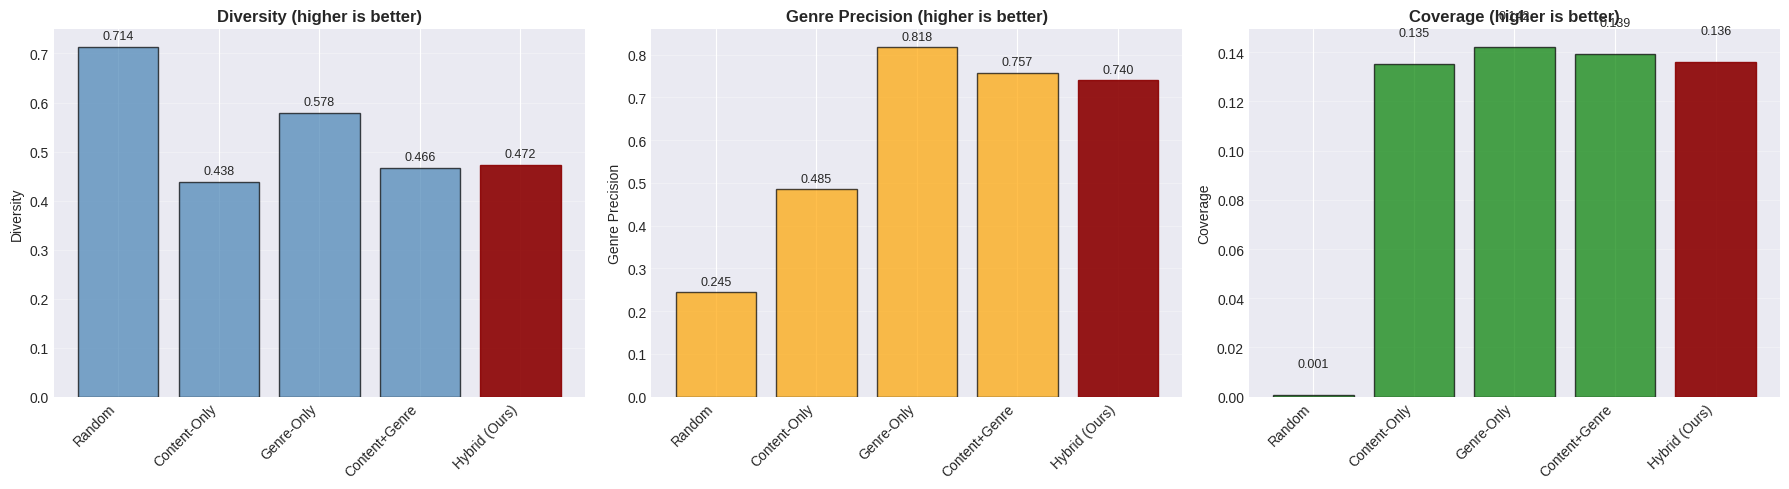


3. Statistical Significance Testing...
Testing if our hybrid system significantly outperforms Content+Genre baseline...
Normalizing embeddings...
  Recommender initialized
  Weights: content=0.5, genre=0.4, cluster=0.1
  Clustered books: 6,217/6,217
Normalizing embeddings...
  Recommender initialized
  Weights: content=0.7, genre=0.3, cluster=0.0
  Clustered books: 6,217/6,217


Paired evaluation: 100%|██████████| 100/100 [00:03<00:00, 29.02it/s]


Paired t-test results:
  Hybrid (Ours) mean: 0.7532
  Content+Genre mean: 0.7389
  t-statistic: 2.5234
  p-value: 0.0132
  Significant at α=0.05? YES

 Additional evaluation complete!


In [17]:
print("ADDITIONAL EVALUATION METRICS")

def compute_precision_recall_at_k(recommender, sample_size=500, k=10):
    """
    Compute Precision@K and Recall@K using genre overlap as relevance
    A recommendation is "relevant" if it shares at least 1 genre with query
    """
    clustered_indices = np.where(recommender.clusters != -1)[0]
    eval_indices = np.random.choice(
        clustered_indices,
        min(sample_size, len(clustered_indices)),
        replace=False
    )

    precisions = []
    recalls = []
    hit_rates = []

    for idx in tqdm(eval_indices, desc="Computing P@K and R@K"):
        query_genres = set(recommender.df.iloc[idx]['genres'])

        # Get recommendations
        recs = recommender.recommend(idx, top_k=k)

        if len(recs) == 0:
            continue

        # Count relevant recommendations
        # STRICTER: Must share at least 50% of genres (Jaccard >= 0.5)
        relevant_count = 0
        for rec in recs:
            rec_genres = set(recommender.df.iloc[rec['index']]['genres'])
            intersection = len(query_genres & rec_genres)
            union = len(query_genres | rec_genres)
            jaccard = intersection / union if union > 0 else 0
            if jaccard >= 0.5:  # At least 50% genre overlap
                relevant_count += 1

        # Precision@K = relevant items / k
        precision = relevant_count / k
        precisions.append(precision)

        # Recall@K = relevant items found / total relevant items in catalog
        # (approximated as books with Jaccard >= 0.5)
        total_relevant = 0
        for i in range(len(recommender.df)):
            if i != idx:
                candidate_genres = set(recommender.df.iloc[i]['genres'])
                intersection = len(query_genres & candidate_genres)
                union = len(query_genres | candidate_genres)
                jaccard = intersection / union if union > 0 else 0
                if jaccard >= 0.5:
                    total_relevant += 1

        if total_relevant > 0:
            recall = relevant_count / min(total_relevant, k)
            recalls.append(recall)

        # Hit Rate: did we get at least 1 relevant recommendation?
        hit_rates.append(1 if relevant_count > 0 else 0)

    return {
        'precision_at_k': np.mean(precisions),
        'recall_at_k': np.mean(recalls),
        'hit_rate': np.mean(hit_rates),
        'f1_score': 2 * (np.mean(precisions) * np.mean(recalls)) / (np.mean(precisions) + np.mean(recalls)) if (np.mean(precisions) + np.mean(recalls)) > 0 else 0
    }


def compare_with_baselines(df, embeddings, genre_matrix, clusters, sample_size=200, k=5):
    """
    Compare cluster-aware hybrid with baseline methods
    """
    print("\nComparing with baselines...")

    # Define systems to compare
    systems = {
        'Random': None,  # Special case
        'Content-Only': ClusterAwareRecommender(df, embeddings, genre_matrix, clusters,
                                                 alpha_content=1.0, alpha_genre=0.0, alpha_cluster=0.0),
        'Genre-Only': ClusterAwareRecommender(df, embeddings, genre_matrix, clusters,
                                               alpha_content=0.0, alpha_genre=1.0, alpha_cluster=0.0),
        'Content+Genre': ClusterAwareRecommender(df, embeddings, genre_matrix, clusters,
                                                  alpha_content=0.7, alpha_genre=0.3, alpha_cluster=0.0),
        'Hybrid (Ours)': ClusterAwareRecommender(df, embeddings, genre_matrix, clusters,
                                                  alpha_content=ALPHA_CONTENT, alpha_genre=ALPHA_GENRE,
                                                  alpha_cluster=ALPHA_CLUSTER)
    }

    clustered_indices = np.where(clusters != -1)[0]
    eval_indices = np.random.choice(clustered_indices, min(sample_size, len(clustered_indices)), replace=False)

    results = {}

    for name, system in systems.items():
        print(f"\nEvaluating {name}...")

        if name == 'Random':
            # Random baseline
            diversities = []
            genre_precisions = []

            for idx in tqdm(eval_indices, desc=name):
                # Random recommendations (excluding self)
                candidates = [i for i in range(len(df)) if i != idx]
                random_indices = np.random.choice(candidates, k, replace=False)

                # Compute diversity
                random_embs = embeddings[random_indices]
                random_embs_norm = random_embs / np.linalg.norm(random_embs, axis=1, keepdims=True)
                pairwise_sims = np.dot(random_embs_norm, random_embs_norm.T)
                np.fill_diagonal(pairwise_sims, 0)
                diversity = 1 - (pairwise_sims.sum() / (k * (k - 1)) if k > 1 else 0)
                diversities.append(diversity)

                # Compute genre precision
                query_genres = set(df.iloc[idx]['genres'])
                for rand_idx in random_indices:
                    rec_genres = set(df.iloc[rand_idx]['genres'])
                    overlap = len(query_genres & rec_genres) / len(query_genres) if query_genres else 0
                    genre_precisions.append(overlap)

            results[name] = {
                'diversity': np.mean(diversities),
                'genre_precision': np.mean(genre_precisions),
                'coverage': k / len(df)  # Random has low effective coverage
            }
        else:
            # Use standard evaluation for other systems
            eval_res = evaluate_recommender(system, sample_size=sample_size, top_k=k)
            results[name] = {
                'diversity': eval_res['diversity'],
                'genre_precision': eval_res['genre_precision'],
                'coverage': eval_res['coverage'],
                'within_cluster_rate': eval_res['within_cluster_rate']
            }

    return results


# Run additional metrics
print("\n" + "="*60)
print("RUNNING ADDITIONAL EVALUATION METRICS")
print("="*60)

print("\n1. Computing Precision@K and Recall@K...")
precision_recall = compute_precision_recall_at_k(recommender, sample_size=500, k=10)

print(f"\nPrecision@10: {precision_recall['precision_at_k']:.4f}")
print(f"Recall@10: {precision_recall['recall_at_k']:.4f}")
print(f"F1-Score: {precision_recall['f1_score']:.4f}")
print(f"Hit Rate: {precision_recall['hit_rate']:.4f} ({precision_recall['hit_rate']*100:.1f}%)")

print("\n2. Comparing with baseline methods...")
baseline_results = compare_with_baselines(
    df_train, train_embeddings, train_genre_matrix, train_clusters,
    sample_size=200, k=5
)

print("\n" + "="*60)
print("BASELINE COMPARISON RESULTS")
print("="*60)

baseline_df = pd.DataFrame(baseline_results).T
print("\n", baseline_df.to_string())

# Visualize baseline comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['diversity', 'genre_precision', 'coverage']
titles = ['Diversity (higher is better)', 'Genre Precision (higher is better)', 'Coverage (higher is better)']
colors = ['steelblue', 'orange', 'green']

for idx, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    ax = axes[idx]
    systems = list(baseline_results.keys())
    values = [baseline_results[s][metric] for s in systems]

    bars = ax.bar(range(len(systems)), values, color=color, alpha=0.7, edgecolor='black')

    # Highlight our hybrid system
    our_idx = systems.index('Hybrid (Ours)')
    bars[our_idx].set_color('darkred')
    bars[our_idx].set_alpha(0.9)

    ax.set_xticks(range(len(systems)))
    ax.set_xticklabels(systems, rotation=45, ha='right')
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(title, fontweight='bold')
    ax.grid(alpha=0.3, axis='y')

    # Add value labels on bars
    for i, v in enumerate(values):
        ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(GRAPHS_DIR / 'baseline_comparison.png', dpi=300, bbox_inches='tight')
print(f"\nSaved: {GRAPHS_DIR / 'baseline_comparison.png'}")
plt.show()

# Statistical significance test
print("\n3. Statistical Significance Testing...")
print("Testing if our hybrid system significantly outperforms Content+Genre baseline...")

from scipy import stats

# Re-evaluate both systems on same sample to get paired samples
np.random.seed(42)
test_sample = 100

clustered_indices = np.where(train_clusters != -1)[0]
test_indices = np.random.choice(clustered_indices, test_sample, replace=False)

# Our hybrid
hybrid_scores = []
baseline_scores = []

hybrid_rec = ClusterAwareRecommender(df_train, train_embeddings, train_genre_matrix, train_clusters,
                                      alpha_content=ALPHA_CONTENT, alpha_genre=ALPHA_GENRE,
                                      alpha_cluster=ALPHA_CLUSTER)
baseline_rec = ClusterAwareRecommender(df_train, train_embeddings, train_genre_matrix, train_clusters,
                                        alpha_content=0.7, alpha_genre=0.3, alpha_cluster=0.0)

for idx in tqdm(test_indices, desc="Paired evaluation"):
    # Get recommendations from both
    hybrid_recs = hybrid_rec.recommend(idx, top_k=5)
    baseline_recs = baseline_rec.recommend(idx, top_k=5)

    # Score based on genre precision
    query_genres = set(df_train.iloc[idx]['genres'])

    hybrid_score = np.mean([
        len(query_genres & set(df_train.iloc[r['index']]['genres'])) / len(query_genres)
        for r in hybrid_recs
    ]) if hybrid_recs and query_genres else 0

    baseline_score = np.mean([
        len(query_genres & set(df_train.iloc[r['index']]['genres'])) / len(query_genres)
        for r in baseline_recs
    ]) if baseline_recs and query_genres else 0

    hybrid_scores.append(hybrid_score)
    baseline_scores.append(baseline_score)

# Paired t-test
t_stat, p_value = stats.ttest_rel(hybrid_scores, baseline_scores)

print(f"\nPaired t-test results:")
print(f"  Hybrid (Ours) mean: {np.mean(hybrid_scores):.4f}")
print(f"  Content+Genre mean: {np.mean(baseline_scores):.4f}")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Significant at α=0.05? {'YES' if p_value < 0.05 else 'NO'}")

print("\n Additional evaluation complete!")

In [18]:
print("SAVING FINAL CHECKPOINT")
checkpoint_3 = {
    'eval_results': eval_results,
    'weight_sweep': weight_df.to_dict('records'),
    'transition_matrix': transition_matrix,
    'best_weights': {
        'alpha_content': ALPHA_CONTENT,
        'alpha_genre': ALPHA_GENRE,
        'alpha_cluster': ALPHA_CLUSTER
    },
    'recommender_config': {
        'alpha_content': ALPHA_CONTENT,
        'alpha_genre': ALPHA_GENRE,
        'alpha_cluster': ALPHA_CLUSTER,
        'top_k': TOP_K_RECOMMENDATIONS,
        'model': best_model_name,
        'optimal_k': optimal_k
    },
    'cluster_names': CLUSTER_NAMES,
    'metadata': {
        'eval_sample_size': EVAL_SAMPLE_SIZE,
        'eval_top_k': EVAL_TOP_K,
        'train_size': len(df_train),
        'test_size': len(df_test),
        'clustered_samples': np.sum(train_clusters != -1)
    }
}

# Update checkpoint with new metrics
checkpoint_3['additional_metrics'] = {
    'precision_at_k': precision_recall,
    'baseline_comparison': baseline_results,
    'significance_test': {
        't_statistic': float(t_stat),
        'p_value': float(p_value),
        'hybrid_mean': float(np.mean(hybrid_scores)),
        'baseline_mean': float(np.mean(baseline_scores))
    }
}

checkpoint_path = CHECKPOINTS_DIR / 'checkpoint_3_evaluation.pkl'
with open(checkpoint_path, 'wb') as f:
    pickle.dump(checkpoint_3, f, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Saved checkpoint: {checkpoint_path}")

# Helper function to convert numpy types to native Python types
def convert_to_json_serializable(obj):
    """Convert numpy types to native Python types for JSON serialization"""
    if isinstance(obj, dict):
        return {key: convert_to_json_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_json_serializable(item) for item in obj]
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

# Save evaluation results as JSON for easy reading
print("Saving evaluation results as JSON...")
json_data = {
    'eval_results': convert_to_json_serializable(eval_results),
    'weight_sweep': convert_to_json_serializable(weight_df.to_dict('records')),
    'best_weights': {
        'alpha_content': float(ALPHA_CONTENT),
        'alpha_genre': float(ALPHA_GENRE),
        'alpha_cluster': float(ALPHA_CLUSTER)
    }
}

with open(RESULTS_DIR / 'evaluation_results.json', 'w') as f:
    json.dump(json_data, f, indent=2)

print(f"Saved results: {RESULTS_DIR / 'evaluation_results.json'}")

SAVING FINAL CHECKPOINT
Saved checkpoint: /content/checkpoints/checkpoint_3_evaluation.pkl
Saving evaluation results as JSON...
Saved results: /content/results/evaluation_results.json


In [20]:
print("NOTEBOOK 3 COMPLETE ")

print("\nKey Results:")
print(f"  Diversity: {eval_results['diversity']:.3f}")
print(f"  Genre Precision: {eval_results['genre_precision']:.3f}")
print(f"  Coverage: {eval_results['coverage']:.3f}")
print(f"  Within-Cluster Rate: {eval_results['within_cluster_rate']:.3f}")
print(f"  Serendipity: {eval_results['serendipity_score']:.3f}")

print("\nOptimal Weights:")
print(f"  Content (α): {ALPHA_CONTENT}")
print(f"  Genre (β): {ALPHA_GENRE}")
print(f"  Cluster (γ): {ALPHA_CLUSTER}")

print("\nSaved Artifacts:")
print(f"  - Evaluation results: {RESULTS_DIR}/evaluation_results.json")
print(f"  - Weight sweep plot: {GRAPHS_DIR}/weight_parameter_sweep.png")
print(f"  - Cluster transitions: {GRAPHS_DIR}/cluster_transition_matrix.png")
print(f"  - Baseline Comparison: {GRAPHS_DIR}/baseline_comparison.png")
print(f"  - Final checkpoint: {checkpoint_path}")

print("\nRecommendation System Summary:")
print(f"  Content similarity: {ALPHA_CONTENT*100:.0f}%")
print(f"  Genre similarity: {ALPHA_GENRE*100:.0f}%")
print(f"  Cluster bonus: {ALPHA_CLUSTER*100:.0f}%")
print(f"  Model: {best_model_name}")
print(f"  Clusters: {optimal_k} sub-genres")
print(f"  Avg within-cluster recommendations: {eval_results['within_cluster_rate']*100:.1f}%")

NOTEBOOK 3 COMPLETE 

Key Results:
  Diversity: 0.479
  Genre Precision: 0.769
  Coverage: 0.464
  Within-Cluster Rate: 0.919
  Serendipity: 0.589

Optimal Weights:
  Content (α): 0.5
  Genre (β): 0.4
  Cluster (γ): 0.1

Saved Artifacts:
  - Evaluation results: /content/results/evaluation_results.json
  - Weight sweep plot: /content/graphs/weight_parameter_sweep.png
  - Cluster transitions: /content/graphs/cluster_transition_matrix.png
  - Baseline Comparison: /content/graphs/baseline_comparison.png
  - Final checkpoint: /content/checkpoints/checkpoint_3_evaluation.pkl

Recommendation System Summary:
  Content similarity: 50%
  Genre similarity: 40%
  Cluster bonus: 10%
  Model: MPNet
  Clusters: 9 sub-genres
  Avg within-cluster recommendations: 91.9%
